# EDA and Statistical Inference

## Contents:

### -- Custom functions to handle repetitive calling of correlations and max therein
### -- Correlations between each feature and the target at various lags
### -- Maximum correlation, which maps to the lag that will be used for each feature
### -- Arrangement of final DF and the feature-only final DF
### -- Correlation heatmap and single- and multi-variable regressions against the target
### -- Subset on the financial crisis (June 2007 - May 2009): heatmap, single-, multi-variable regression
### -- Univariate statistics and histograms for the target, (a) over the entire period, and (b) during the financial crisis
### -- Univariate statistics and histograms for the features, (a) over the entire period, and (b) during the financial crisis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
%matplotlib inline

### The below EDA, statistical analysis, and plots will be assembled into slides and the final write-up

In [2]:
df = pd.read_csv('DF.csv', header=0, index_col=0, parse_dates=True)

In [3]:
df.index = df.index.strftime('%Y-%m')

In [4]:
## create custom function that computes the correlation between one of the features at various lags and the target

def diff_corr(df_col):
    lag_0 = np.corrcoef(df_col.loc['1998-04':].values, df['Spread'].loc['1998-04':].values)[0,1]
    lag_1 = np.corrcoef(df_col.loc['1998-03':'2018-11'].values, df['Spread'].loc['1998-04':].values)[0,1]
    lag_2 = np.corrcoef(df_col.loc['1998-02':'2018-10'].values, df['Spread'].loc['1998-04':].values)[0,1]
    lag_3 = np.corrcoef(df_col.loc['1998-01':'2018-09'].values, df['Spread'].loc['1998-04':].values)[0,1]
    return {'lag 0': round(abs(lag_0),4), 'lag 1': round(abs(lag_1),4), 'lag 2': round(abs(lag_2),4), \
            'lag 3': round(abs(lag_3),4)}

## create custom function that returns the key (from a dictionary generated by a function) with the maximum value

def max_corr(df_col, func=diff_corr):
    return max(func(df_col), key=func(df_col).get)

In [5]:
print('Compute the correlation for all features except fixed income:\n')

print('Activity:', diff_corr(df['CFNAI']))
print('Inflation:', diff_corr(df['CPI']))
print('Money Supply:', diff_corr(df['M2']))
print('Manufacturing:', diff_corr(df['ISM']))
print('Dividend Yield:', diff_corr(df['divy']))

Compute the correlation for all features except fixed income:

Activity: {'lag 0': 0.2663, 'lag 1': 0.3443, 'lag 2': 0.3609, 'lag 3': 0.326}
Inflation: {'lag 0': 0.1583, 'lag 1': 0.189, 'lag 2': 0.2106, 'lag 3': 0.1669}
Money Supply: {'lag 0': 0.1461, 'lag 1': 0.203, 'lag 2': 0.2189, 'lag 3': 0.2023}
Manufacturing: {'lag 0': 0.2961, 'lag 1': 0.1163, 'lag 2': 0.0496, 'lag 3': 0.1752}
Dividend Yield: {'lag 0': 0.2317, 'lag 1': 0.2697, 'lag 2': 0.2701, 'lag 3': 0.256}


In [6]:
print('Select best correlation for each feature:\n')

print('Activity:', max_corr(df['CFNAI']))
print('Inflation:', max_corr(df['CPI']))
print('Money Supply:', max_corr(df['M2']))
print('Manufacturing:', max_corr(df['ISM']))
print('Dividend Yield:', max_corr(df['divy']))

Select best correlation for each feature:

Activity: lag 2
Inflation: lag 2
Money Supply: lag 2
Manufacturing: lag 0
Dividend Yield: lag 2


In [7]:
print('Fixed income correlations with the target at various lags:\n')

print('lag 2:', np.corrcoef(df['bfly'].loc['1998-01':'2018-10'].values, df['Spread'].loc['1998-03':].values)[0,1])
print('lag 4:', np.corrcoef(df['bfly'].loc['1998-01':'2018-08'].values, df['Spread'].loc['1998-05':].values)[0,1])
print('lag 6:', np.corrcoef(df['bfly'].loc['1998-01':'2018-06'].values, df['Spread'].loc['1998-07':].values)[0,1])
print('lag 8:', np.corrcoef(df['bfly'].loc['1998-01':'2018-04'].values, df['Spread'].loc['1998-09':].values)[0,1])
print('lag 10:', np.corrcoef(df['bfly'].loc['1998-01':'2018-02'].values, df['Spread'].loc['1998-11':].values)[0,1])

print('\nThe butterfly spread will be lagged at eight months')

Fixed income correlations with the target at various lags:

lag 2: -0.007671404356166322
lag 4: -0.07919841800673687
lag 6: -0.12423375777785835
lag 8: -0.13777004592534953
lag 10: -0.11178310080542919

The butterfly spread will be lagged at eight months


In [8]:
##### lag the features accordingly

df['CFNAI'] = df['CFNAI'].shift(2)
df['CPI'] = df['CPI'].shift(2)
df['M2'] = df['M2'].shift(2)
df['bfly'] = df['bfly'].shift(8)
df['divy'] = df['divy'].shift(2)

##### create Boolean target

df['Spread_bool'] = df['Spread'].apply(lambda x: 1 if x > 0 else 0)

##### final matrix containing both features and the target

df = df.loc['1998-09':'2018-12']

df.head()

,CFNAI,CPI,M2,ISM,bfly,divy,Spread,Spread_bool
1998-09,-0.714668,0.017456,0.071958,-0.015936,-0.12,1.811985,-0.149674,0
1998-10,1.586036,0.016169,0.067402,-0.073359,-0.07,2.113960,-0.102204,0
1998-11,-0.100069,0.014268,0.076094,-0.051081,-0.30,2.072709,-0.049126,0
1998-12,0.396017,0.014861,0.082254,0.006073,-0.45,2.032636,-0.011147,0
1999-01,0.109703,0.014842,0.082479,0.091667,-0.33,1.984063,0.065041,1


In [9]:
##### matrix containing just features

df_features = df.drop(['Spread', 'Spread_bool'], axis=1)

df_features.head()

,CFNAI,CPI,M2,ISM,bfly,divy
1998-09,-0.714668,0.017456,0.071958,-0.015936,-0.12,1.811985
1998-10,1.586036,0.016169,0.067402,-0.073359,-0.07,2.113960
1998-11,-0.100069,0.014268,0.076094,-0.051081,-0.30,2.072709
1998-12,0.396017,0.014861,0.082254,0.006073,-0.45,2.032636
1999-01,0.109703,0.014842,0.082479,0.091667,-0.33,1.984063


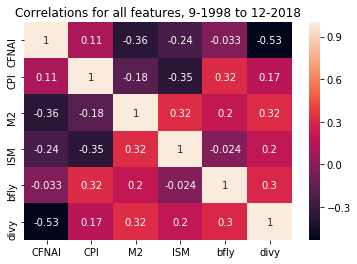

In [10]:
##### heatmap showing correlations among features

sns.heatmap(df_features.corr(), annot=True)
plt.title('Correlations for all features, 9-1998 to 12-2018')
plt.show()

In [11]:
##### construct dataframe of t-stats, p-values, and R-squared

regressors = list(df.columns)[:-2]
model = ols('CFNAI ~ CPI', data=df).fit()
#print(model.summary())
regressors2 = [i + ' only' for i in regressors]
testlist = [model.tvalues[1], model.pvalues[1], model.rsquared]

OLS_results = []

for i in regressors:
    regmodel = ols('Spread ~ ' + i, data=df).fit()
    OLS_results.append([regmodel.tvalues[1], regmodel.pvalues[1], regmodel.rsquared])

OLS_results

print('Single Linear Regression Using Each Feature:')

pd.DataFrame(dict(zip(regressors2, OLS_results)), index=['t-stat', 'p-value', 'R-squared'])

Single Linear Regression Using Each Feature:


,CFNAI only,CPI only,M2 only,ISM only,bfly only,divy only
t-stat,-6.253222e+00,-3.335435,3.536803,4.945411,-2.163833,4.381291
p-value,1.805060e-09,0.000985,0.000485,0.000001,0.031456,0.000018
R-squared,1.391049e-01,0.043951,0.049149,0.091786,0.018981,0.073492


In [12]:
##### joint regression

multi_reg = ols('Spread ~ CFNAI + CPI + M2 + ISM + bfly + divy', data=df).fit()
print(multi_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     12.02
Date:                Thu, 16 May 2019   Prob (F-statistic):           8.87e-12
Time:                        11:25:50   Log-Likelihood:                 295.43
No. Observations:                 244   AIC:                            -576.9
Df Residuals:                     237   BIC:                            -552.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0478      0.026     -1.834      0.0

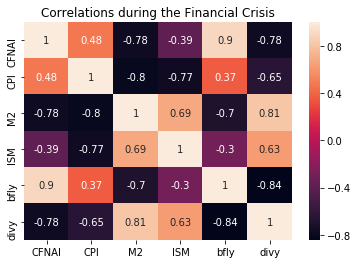

In [13]:
##### subset on the financial crisis -- June 2007 to May 2009 (no hard-and-fast 'begin' and 'end' dates)

#### correlation heatmap during the financial crisis

df_fc = df.loc['2007-06':'2009-05']

df_fc_features = df_fc.drop(['Spread', 'Spread_bool'], axis=1)
df_fc_features.corr()

sns.heatmap(df_fc_features.corr(), annot=True)
plt.title('Correlations during the Financial Crisis')
plt.show()


In [14]:
#### single-variable regression for all features

OLS_results2 = []

for j in regressors:
    regmodel2 = ols('Spread ~ ' + j, data=df_fc).fit()
    OLS_results2.append([regmodel2.tvalues[1], regmodel2.pvalues[1], regmodel2.rsquared])

OLS_results2

print('Single Linear Regression during the Financial Crisis Using Each Feature:')

pd.DataFrame(dict(zip(regressors2, OLS_results2)), index=['t-stat', 'p-value', 'R-squared'])

Single Linear Regression during the Financial Crisis Using Each Feature:


,CFNAI only,CPI only,M2 only,ISM only,bfly only,divy only
t-stat,-4.294283,-6.817267e+00,7.219274e+00,5.103532,-2.926229,5.119105
p-value,0.000294,7.542725e-07,3.107443e-07,0.000041,0.007820,0.000040
R-squared,0.455996,6.787155e-01,7.031757e-01,0.542106,0.280171,0.543618


In [15]:
#### multi-variate regression during the financial crisis

multi_reg_fc = ols('Spread ~ CFNAI + CPI + M2 + ISM + bfly + divy', data=df_fc).fit()
print(multi_reg_fc.summary())


                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     13.75
Date:                Thu, 16 May 2019   Prob (F-statistic):           1.07e-05
Time:                        11:26:00   Log-Likelihood:                 28.441
No. Observations:                  24   AIC:                            -42.88
Df Residuals:                      17   BIC:                            -34.64
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2532      0.290     -0.875      0.3

In [16]:
################# mean and std for the spread over the entire period and during the financial crisis

print('The mean over the entire period is close to zero.  Given that the target is the difference between two portfolios, \
we interpret this to mean that in any given one, neither portfolio can be expected to outperform the other.  The standard \
deviation more than doubles during the financial crisis, a period of significant financial distress.')

pd.DataFrame([dict({'Mean': df['Spread'].mean(), 'Mean: financial crisis': df_fc['Spread'].mean(), \
                   'Std': df['Spread'].std(), 'Std: financial crisis': df_fc['Spread'].std()})], index=['Spread'])

The mean over the entire period is close to zero.  Given that the target is the difference between two portfolios, we interpret this to mean that in any given one, neither portfolio can be expected to outperform the other.  The standard deviation more than doubles during the financial crisis, a period of significant financial distress.


,Mean,Mean: financial crisis,Std,Std: financial crisis
Spread,-0.00213,0.027061,0.082509,0.182827


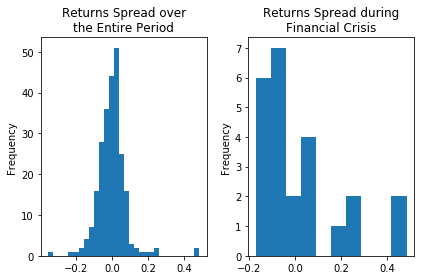

Over the entire period, the returns spread appears to closely approximate the normal distribution.  During the financial crisis, notwithstanding fewer observations, the distribution is far less normal and far more skewed.


In [17]:
################# histograms for the spread over the entire period and during the financial crisis

plt.subplot(1, 2, 1)
df['Spread'].plot('hist', bins=30)
plt.title('Returns Spread over\nthe Entire Period')

plt.subplot(1, 2, 2)
df_fc['Spread'].plot('hist')
plt.title('Returns Spread during\nFinancial Crisis')
plt.tight_layout()
plt.show()

print('Over the entire period, the returns spread appears to closely approximate the normal distribution.  During the \
financial crisis, notwithstanding fewer observations, the distribution is far less normal and far more skewed.')

In [18]:
##### mean and standard deviation for the features

mean_and_sd = df.iloc[:,:-2].describe()[1:3]
mean_and_sd_fc = df_fc.iloc[:,:-2].describe()[1:3]

all_mean_and_sd = pd.concat([mean_and_sd, mean_and_sd_fc], ignore_index=True)
all_mean_and_sd.index = ['Mean', 'SD', 'Mean during Financial Crisis', 'SD during Financial Crisis']

print('Outside of money supply (M2), all features witness the effects of the financial crisis in terms of mean and/or \
standard deviation.  Specifically, the activity metric CFNAI\'s mean plunges sevenfold while its standard deviation \
almost doubles.  Further, the butterfly spread\'s mean decreases threefold while the dividend yield spread\'s mean more \
than doubles.  These reactions to the crisis are intuitive: during crises, economic activity tends to decline sharply, \
and the yield curve, for which the butterfly spread proxies, tends to tighten and/or invert itself.  The dividend yield \
spread declines because value stocks usually witness greater declines than growth stocks do during crises.  The dividend \
yield spread is the difference in dividend yield of the value and growth portfolios.  Since value stocks witness greater \
declines than growth stocks, the dividend yield will rise more greatly for the value portfolio than it will for the \
growth portfolio.')

all_mean_and_sd

Outside of money supply (M2), all features witness the effects of the financial crisis in terms of mean and/or standard deviation.  Specifically, the activity metric CFNAI's mean plunges sevenfold while its standard deviation almost doubles.  Further, the butterfly spread's mean decreases threefold while the dividend yield spread's mean more than doubles.  These reactions to the crisis are intuitive: during crises, economic activity tends to decline sharply, and the yield curve, for which the butterfly spread proxies, tends to tighten and/or invert itself.  The dividend yield spread declines because value stocks usually witness greater declines than growth stocks do during crises.  The dividend yield spread is the difference in dividend yield of the value and growth portfolios.  Since value stocks witness greater declines than growth stocks, the dividend yield will rise more greatly for the value portfolio than it will for the growth portfolio.


,CFNAI,CPI,M2,ISM,bfly,divy
Mean,-0.219225,0.021768,0.063244,0.009435,-1.197850,1.157314
SD,0.841540,0.012320,0.018001,0.130638,0.939827,0.853867
Mean during Financial Crisis,-1.581749,0.030206,0.069890,0.006234,-0.393104,2.586362
SD during Financial Crisis,1.462336,0.017985,0.014386,0.265173,0.928604,1.035098


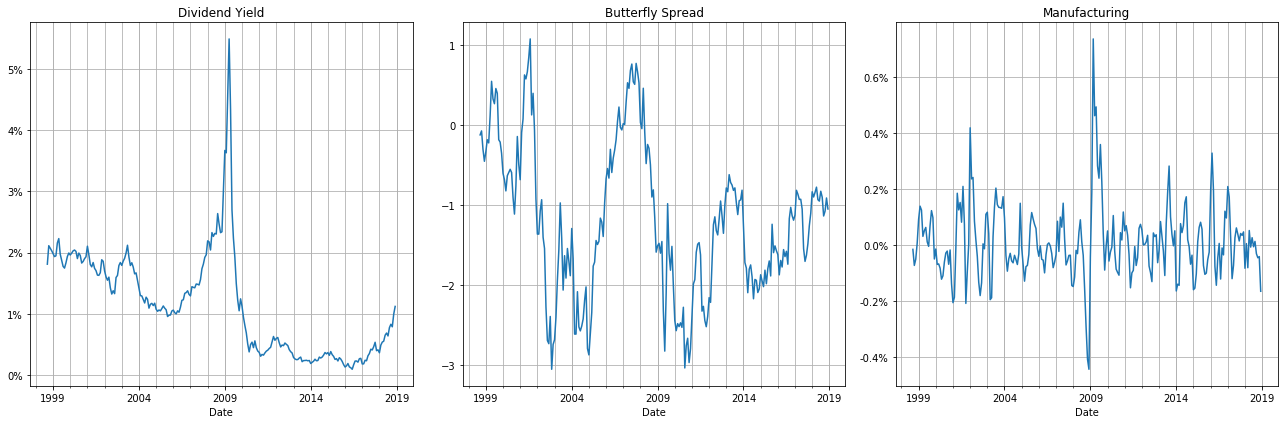

<Figure size 432x288 with 0 Axes>

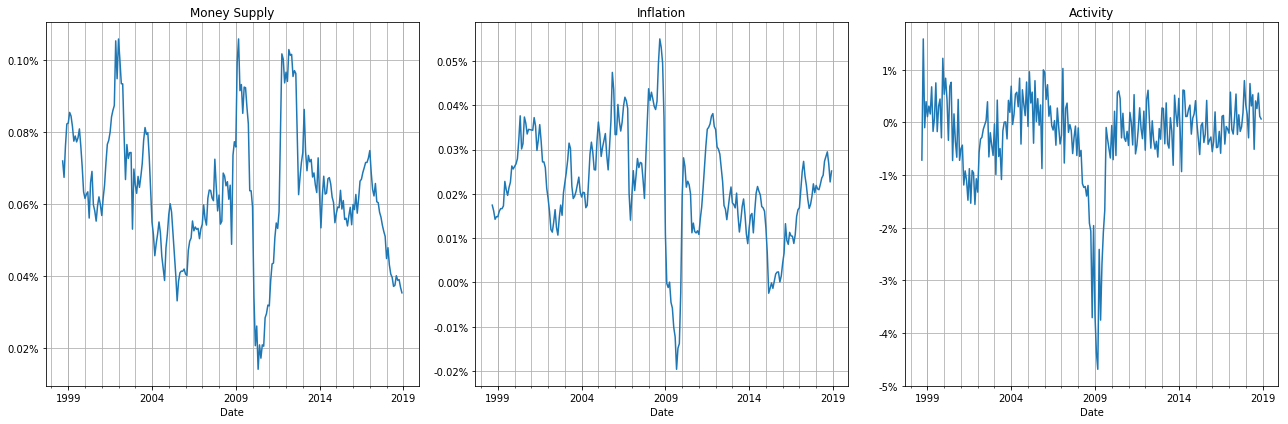

<Figure size 432x288 with 0 Axes>

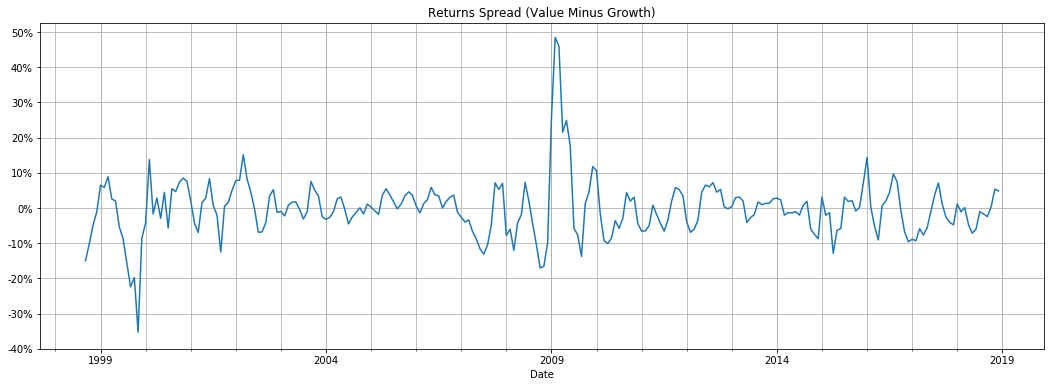

In [19]:
####### plots for all features
### create new df with the index reset, so that 'date' becomes a feature that can be called in plt.plot()

# coerce index to datetime so that dates can appear on the x-axes

df.index = pd.to_datetime(df.index.astype(str))

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

ax = df.reset_index().plot(x='index', y='divy', legend=False, ax=axs[0])
ax.set(title='Dividend Yield', xlabel='Date')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x/100) for x in vals])
ax.grid(which='both')

ax = df.reset_index().plot(x='index', y='bfly', legend=False, ax=axs[1])
ax.set(title='Butterfly Spread', xlabel='Date')
ax.grid(which='both')

ax = df.reset_index().plot(x='index', y='ISM', legend=False, ax=axs[2])
ax.set(title='Manufacturing', xlabel='Date')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x/100) for x in vals])
ax.grid(which='both')

plt.tight_layout()
plt.show()

plt.clf()

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

ax = df.reset_index().plot(x='index', y='M2', legend=False, ax=axs[0])
ax.set(title='Money Supply', xlabel='Date')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x/100) for x in vals])
ax.grid(which='both')

ax = df.reset_index().plot(x='index', y='CPI', legend=False, ax=axs[1])
ax.set(title='Inflation', xlabel='Date')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x/100) for x in vals])
ax.grid(which='both')

ax = df.reset_index().plot(x='index', y='CFNAI', legend=False, ax=axs[2])
ax.set(title='Activity', xlabel='Date')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x/100) for x in vals])
ax.grid(which='both')

plt.tight_layout()
plt.show()

plt.clf()

fig, ax = plt.subplots(1, 1, figsize=(18, 6))

ax = df.reset_index().plot(x='index', y='Spread', legend=False, ax=ax)
ax.set(title='Returns Spread (Value Minus Growth)', xlabel='Date')
ax.set_yticks(np.linspace(-0.4, 0.5, num=10))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.grid(which='both')

plt.show()

In [20]:
#### export df

df.to_csv('model.csv')